In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('final.csv')
df.columns=columns=['mensaje','sentimiento']
df.head()

,mensaje,sentimiento
0,15 p. m. - Los mensajes y las llamadas están c...,-2
1,"14 p. m. - ‎Gabo CD creó el grupo ""Ciencia de ...",-2
2,15 p. m. - Te uniste mediante el enlace de inv...,-2
3,15 p. m. - ‎Gustavo Alvarez se unió usando el ...,-2
4,25 p. m. - ‎Francisco CD se unió usando el enl...,-2


In [3]:
df=df.drop(df[df['sentimiento']<-1].index)

In [4]:
df.groupby('sentimiento').size()

sentimiento
-1     40
 0    309
 1    113
dtype: int64

In [5]:
# Misc
from warnings import filterwarnings

# Data Wrangling
import re
import numpy as np
import pandas as pd

# Data visualization
from PIL import Image
import cufflinks as cf
from stylecloud import gen_stylecloud

# Modeling
from keras import metrics
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocessing
import nltk
import unicodedata
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model performance
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

2022-11-05 22:26:17.213261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 22:26:17.570477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 22:26:17.570499: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-05 22:26:17.610757: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-05 22:26:20.987624: W tensorflow/stream_executor/platform/de

In [6]:
# Environment setup
cf.go_offline()
nltk.download("all")
filterwarnings("ignore")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/mariano/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[

[nltk_data]    |   Package omw is already up-to-date!
[nltk_data]    | Downloading package omw-1.4 to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package omw-1.4 is already up-to-date!
[nltk_data]    | Downloading package opinion_lexicon to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package opinion_lexicon is already up-to-date!
[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package panlex_swadesh is already up-to-date!
[nltk_data]    | Downloading package paradigms to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package paradigms is already up-to-date!
[nltk_data]    | Downloading package pe08 to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package pe08 is already up-to-date!
[nltk_data]    | Downloading package perluniprops to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package perluniprops is alre

[nltk_data]    |   Package wordnet31 is already up-to-date!
[nltk_data]    | Downloading package wordnet_ic to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package words is already up-to-date!
[nltk_data]    | Downloading package ycoe to
[nltk_data]    |     /home/mariano/nltk_data...
[nltk_data]    |   Package ycoe is already up-to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection all


In [7]:
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    """Cleans the text to facilitate its analysis, it changes accented letters to its quivalent without accents, removes also special characters

    Parameters
    ----------
    text : string
        String containing text
    pattern : str, optional
        Regular expession for keeping in the string, by default ``[^a-zA-Z0-9 ]``

    Returns
    -------
    cleaned_text : string
        Cleaned string

    Example
    -------
    >>> clean_text('¡Feliz año nuevo, México!')
    >>> u'feliz ano nuevo mexico'
    """
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, " ", cleaned_text.decode("utf-8"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().split())
    return cleaned_text

In [8]:
clean_text("¡Feliz año nuevo, México!")

'feliz ano nuevo mexico'

In [9]:
def get_wordcloud(text, icon="fas fa-comments", background_color=None, output_name="./wordcloud.png"):
    # https://fontawesome.com/icons/alicorn?s=solid
    gen_stylecloud(text=text, icon_name=icon, background_color=background_color, output_name=output_name)
    return Image.open(output_name)

In [10]:
dc_cat = df["sentimiento"].value_counts().to_dict()

In [11]:
smallest = min(dc_cat, key=dc_cat.get)
n_min = min(dc_cat.values())

In [12]:
df = pd.concat([df[df["sentimiento"]==sent].sample(n_min) for sent in df["sentimiento"].unique()]).reset_index(drop=True)

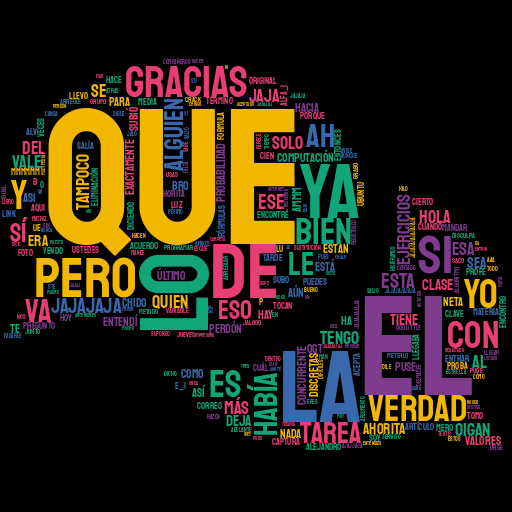

In [13]:
get_wordcloud(text = " ".join(df["mensaje"]))

In [14]:
stop_words = [clean_text(x) for x in stopwords.words("spanish")]

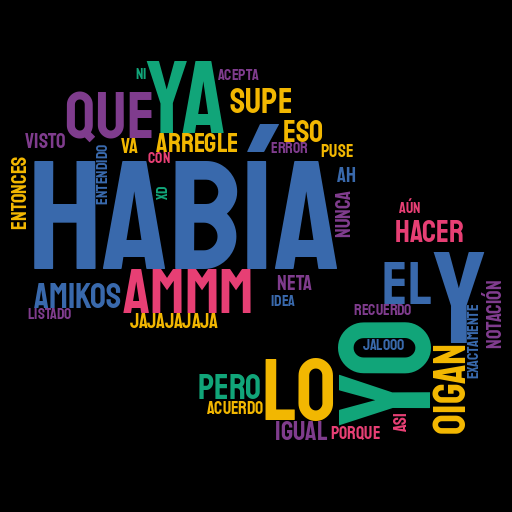

In [15]:
get_wordcloud(text = " ".join(df["mensaje"].sample(frac=0.1)))

In [16]:
df["words"] = df["mensaje"].str.split()

In [17]:
df["words"].str.len().describe(percentiles=[.95])

count    120.000000
mean       4.758333
std        4.060459
min        1.000000
50%        3.500000
95%       12.000000
max       24.000000
Name: words, dtype: float64

In [18]:
MAX_NB_WORDS = 250
MAX_SEQUENCE_LENGTH = 15
EMBEDDING_DIM = 3


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['mensaje'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 304 unique tokens.


In [19]:
X = tokenizer.texts_to_sequences(df['mensaje'].values)

In [20]:
len(X)

120

In [21]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (120, 15)


In [22]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (120, 15)


In [23]:
le = LabelEncoder()

In [24]:
y = le.fit_transform(df["sentimiento"])

In [25]:
y = to_categorical(y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2, shuffle=True)

In [27]:
model = Sequential()

2022-11-05 22:26:37.338126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-05 22:26:37.338206: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-05 22:26:37.338268: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mariano-Lenovo-IdeaPad-S145-14IKB): /proc/driver/nvidia/version does not exist
2022-11-05 22:26:37.338977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model.add(LSTM(3, activation="tanh"))

In [29]:
model.add(Dense(5, activation="sigmoid"))

In [30]:
model.add(Dense(len(le.classes_), activation='softmax'))

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.0000001)

In [41]:
checkpoint = ModelCheckpoint('checkpoint'
    ,save_best_only=True,
                             save_weights_only=False,
                             monitor='val_accuracy')

In [42]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=1024, callbacks=[early_stopping, checkpoint], validation_data=(X_test, y_test))

Epoch 1/1000


ValueError: in user code:

    File "/home/mariano/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/mariano/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mariano/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/mariano/.local/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/mariano/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/mariano/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 15)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 15), dtype=int32)
      • training=True
      • mask=None
